# Pytorch: Examining the Titanic Sinking with Ridge Regression
## Examining the Data of more than 800 Titanic Passengers and training a Machine Learning Model on it

In this notebook we shall use [this](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html) dataset containing data about passengers from the Titanic. Based on this data we will use a Ridge Regression model which just means a Logistic Regression model that uses L2 Regularization for predicting whether a person survived the sinking based on their passenger class, sex, the number of their siblings/spouses aboard, the number of their parents/children aboard and the fare they payed.

First we import everything we need for plotting data and creating a great model to make predictions on the data.

In [1]:
import pandas as pd
import numpy as np
import torch
import jovian
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

## Data Exploration

Here we can see what the data actually looks like. The first column indicates whether the person survived with a 1 or a 0 where the 1 stands for survival and the 0 for death. The rest of the columns are all our input columns used to predict the survival. We will however forget about as it does not hold important information needed to predict survival. You can also see below that we have 887 persons with their data and 8 total columns where 6 of them will be the input values and 1 of them (the Survived column) the corresponding label.

In [2]:
dataframe = pd.read_csv("./data/titanic.csv")
dataframe.head(10)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
8,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27.0,0,2,11.1333
9,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14.0,1,0,30.0708


In [3]:
len(dataframe.index)

887

In [4]:
len(dataframe.columns)

8

Now to get a little bit more familiar with the data we can do some computations with it and plot it. First we print how big the part of the survivors is which can also be described as the total probability of survival.

In [5]:
print("Total probability of survival for all passengers -->  {:.4f}".format(dataframe.Survived.mean()))

Total probability of survival for all passengers -->  0.3856


When we look at how likely different people from different classes and of different sexes are to survive we can see a clear trend that the higher the class the higher the survival probability and also that women are much more likely to survive. But why is this the case. The answer is quite simple. When the Titanic began to sink women and children should go offboard in the lifeboats first before the men and the lower classes were not treated equally during the sinking as there were so many people in those classes that they could not be informed as well by the stewardesses so that it took mutch longer for them to get to the deck for rescue while first and second class passengers were already boarding the lifeboats and then the sailors fastened down the hatchways leading to the third-class section. They said they wanted to keep the air down there so the vessel could stay up longer. It meant all hope was gone for those still down there. Another reason why there where so many people dying was the missing safety measures onboard the Titanic. For example there where not enough boats for the passengers to escape the ship. The lifeboats would have been only sufficient for half the people onboard and due to bad organization not all of them were completely filled so that even more than half of the passengers was left behind. One good aspect, however, is that the laws for a ships safety have become much more strict after this disaster. If you want to read about the sinking in detail have a look at this: <https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic>

In [6]:
# How likely is survival??
print("Survival probability for female in first class -->  {:.4f}".format(len(dataframe[(dataframe["Survived"]==1) & (dataframe["Sex"]=="female") & (dataframe["Pclass"]==1)].index) / len(dataframe[(dataframe["Sex"]=="female") & (dataframe["Pclass"]==1)].index)))
print("Survival probability for female in second class -->  {:.4f}".format(len(dataframe[(dataframe["Survived"]==1) & (dataframe["Sex"]=="female") & (dataframe["Pclass"]==2)].index) / len(dataframe[(dataframe["Sex"]=="female") & (dataframe["Pclass"]==2)].index)))
print("Survival probability for female in third class -->  {:.4f}".format(len(dataframe[(dataframe["Survived"]==1) & (dataframe["Sex"]=="female") & (dataframe["Pclass"]==3)].index) / len(dataframe[(dataframe["Sex"]=="female") & (dataframe["Pclass"]==3)].index)))
print("")
print("Survival probability for male in first class -->  {:.4f}".format(len(dataframe[(dataframe["Survived"]==1) & (dataframe["Sex"]=="male") & (dataframe["Pclass"]==1)].index) / len(dataframe[(dataframe["Sex"]=="male") & (dataframe["Pclass"]==1)].index)))
print("Survival probability for male in second class -->  {:.4f}".format(len(dataframe[(dataframe["Survived"]==1) & (dataframe["Sex"]=="male") & (dataframe["Pclass"]==2)].index) / len(dataframe[(dataframe["Sex"]=="male") & (dataframe["Pclass"]==2)].index)))
print("Survival probability for male in third class -->  {:.4f}".format(len(dataframe[(dataframe["Survived"]==1) & (dataframe["Sex"]=="male") & (dataframe["Pclass"]==3)].index) / len(dataframe[(dataframe["Sex"]=="male") & (dataframe["Pclass"]==3)].index)))

Survival probability for female in first class -->  0.9681
Survival probability for female in second class -->  0.9211
Survival probability for female in third class -->  0.5000

Survival probability for male in first class -->  0.3689
Survival probability for male in second class -->  0.1574
Survival probability for male in third class -->  0.1370


Looking at the prices which are all in measured in pounds we can see the total average fare and then the different ones from the different classes. Note that due to inflation these numbers measured in pounds today would be quite a bit higher.

In [7]:
print("Average fare of all passengers -->   {:.4f}".format(dataframe.Fare.mean()))
# How much you have to pay for the different classes in average?? (price unit is £/pounds)
print("First class mean cost -->  {:.4f}".format(dataframe[dataframe["Pclass"]==1].Fare.mean()))
print("Second class mean cost -->  {:.4f}".format(dataframe[dataframe["Pclass"]==2].Fare.mean()))
print("Third class mean cost -->  {:.4f}".format(dataframe[dataframe["Pclass"]==3].Fare.mean()))

Average fare of all passengers -->   32.3054
First class mean cost -->  84.1547
Second class mean cost -->  20.6622
Third class mean cost -->  13.7077


There are also people from all ages on board while the average age is 30 years.

In [8]:
# average age of all passengers
print("Average age of all passengers -->  {0:.1f}".format(dataframe.Age.mean()))
print("Age of oldest passenger -->  {:.1f}".format(dataframe.Age.max()))
print("Age of youngest passenger -->  {:.1f}".format(dataframe.Age.min()))

Average age of all passengers -->  29.5
Age of oldest passenger -->  80.0
Age of youngest passenger -->  0.4


To see the difference of survival probalilty already mentioned an explained above more visually we can plot them like the following plots show. Here you can see the difference between the different classes and sex very well.

Text(0.5, 1.0, 'No. of survivors and dead')

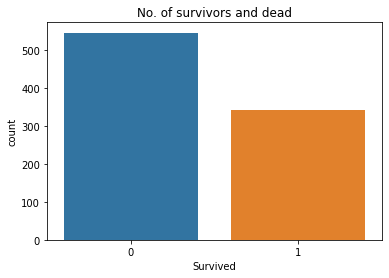

In [9]:
sns.countplot(dataframe.Survived)
plt.title("No. of survivors and dead")

Text(0.5, 1.0, 'No. of people survived and died separated into women and men')

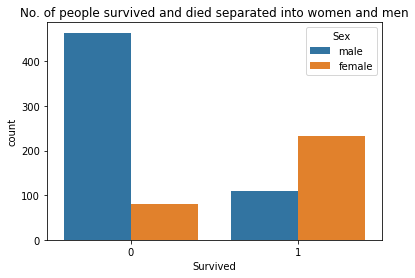

In [10]:
sns.countplot(x="Survived", hue="Sex", data=dataframe)
plt.title("No. of people survived and died separated into women and men")

Text(0.5, 1.0, 'No. of people survived from different classes')

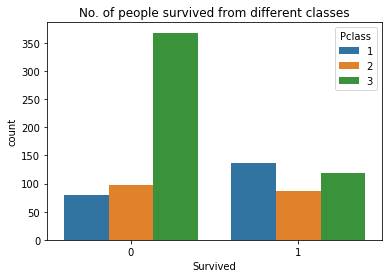

In [11]:
sns.countplot(x="Survived", hue="Pclass", data=dataframe)
plt.title("No. of people survived from different classes")

Let's now look at the fare distribution and the costs from the different classes.

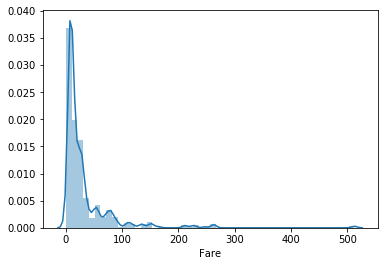

In [12]:
sns.distplot(dataframe.Fare)

Text(0.5, 1, 'Average pricing for different classes in £')

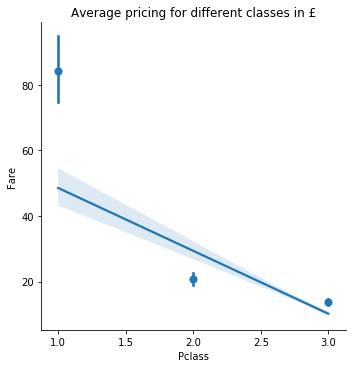

In [13]:
# Average pricing for different classes
sns.lmplot(x="Pclass", y="Fare", data=dataframe, y_jitter=.03, x_estimator=np.mean, robust=True)
plt.title("Average pricing for different classes in £")

In the following we can see very well that most passengers did not have any siblings/spouses or parents/children aboard.

Text(0.5, 1.0, 'Number of siblings and spouses on board of each passenger')

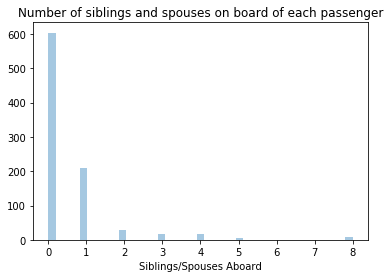

In [14]:
sns.distplot(dataframe["Siblings/Spouses Aboard"], kde=False)
plt.title("Number of siblings and spouses on board of each passenger")

Text(0.5, 1.0, 'Number of parents and children on board of each passenger')

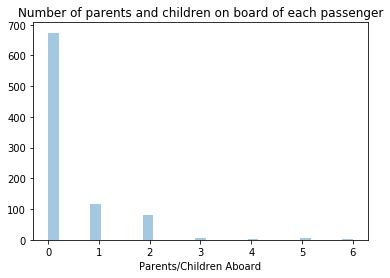

In [15]:
sns.distplot(dataframe["Parents/Children Aboard"], kde=False)
plt.title("Number of parents and children on board of each passenger")

Lastly we look at the distribution of the ages of the passengers.

Text(0.5, 1.0, 'Ages of passengers')

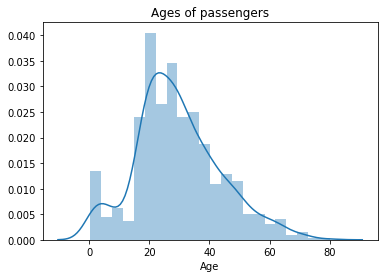

In [16]:
sns.distplot(dataframe.Age)
plt.title("Ages of passengers")

## Data Preparation

Now to be able to train our model we want to convert our pandas dataframe into pytorch tensors. To do this we define the `dataframe_to_arrays` method which does the conversion to numpy arrays. To use the function we need to specify 3 kinds of columns namely input columns, categorical columns (columns that do not contain numbers but rather a string standing for a category) and output columns so that it can properly create a numpy array for input data and labels with all input data from the input columns (by first converting the categorical columns to numerical ones) and the labels from the output columns. Then we can easily convert them to pytorch tensors and specify the desired data types so that we are ready to define the model to be ready for the training on the data. Note also that the `normalize` parameter is set to `True` which makes the function normalize the input data by sqishing all values in a range between 0 and 1 with Min Max Normalization for the model to be able to better learn from the data as it is more uniform now.

In [17]:
input_cols = [title for title in dataframe.columns[1:] if title != 'Name']
input_cols

['Pclass',
 'Sex',
 'Age',
 'Siblings/Spouses Aboard',
 'Parents/Children Aboard',
 'Fare']

In [18]:
categorical_cols = ["Sex"]
output_cols = ["Survived"]

In [19]:
def dataframe_to_arrays(dataframe, normalize=False, labeled=True, cols=input_cols):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    
    # normalize the input data with min max normalization
    if normalize:
        for col in cols:
            dataframe1[col] = (dataframe1[col] - dataframe1[col].min()) / (dataframe1[col].max() - dataframe1[col].min())
    # Extract input & outputs as numpy arrays
    inputs_array = dataframe1[cols].to_numpy()
    if labeled:
        targets_array = dataframe1[output_cols].to_numpy().reshape(-1,1)
        return inputs_array, targets_array
    else:
        return inputs_array

In [20]:
input_arr, target_arr = dataframe_to_arrays(dataframe, normalize=True)
input_arr, target_arr

(array([[1.        , 1.        , 0.27117366, 0.125     , 0.        ,
         0.01415106],
        [0.        , 0.        , 0.4722292 , 0.125     , 0.        ,
         0.13913574],
        [1.        , 0.        , 0.32143755, 0.        , 0.        ,
         0.01546857],
        ...,
        [1.        , 0.        , 0.08268409, 0.125     , 0.33333333,
         0.04577135],
        [0.        , 1.        , 0.32143755, 0.        , 0.        ,
         0.0585561 ],
        [1.        , 1.        , 0.39683338, 0.        , 0.        ,
         0.01512699]]),
 array([[0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0

In [21]:
inputs = torch.tensor(input_arr, dtype=torch.float32)
targets = torch.tensor(target_arr, dtype=torch.float32)

Now that we have the pytorch tensors for the input data and the labels we put them into a pytorch `TensorDataset` which contains pairs of inputs and labels.

In [22]:
dataset = TensorDataset(inputs, targets)

In [23]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([6]) tensor([0.])


Another thing we have to do is that we split the original dataset into 1 for training the model and another one for validating that the model is learning something which means that the validation dataset contains data that the model has never seen before and by making predictions on it we can see how well the model can perform on unknown data. This accuracy from the validation data will be used as a metric for all training epochs as well as the loss on the validation data.

In [24]:
validation_part = 0.1
validation_size = int(validation_part*len(dataset))
train_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset, [train_size, validation_size])
len(train_ds), len(val_ds)

(799, 88)

Last thing we do with our data is to put it into a `DataLoader` (one for the validation data and one for the training data) which will be used to train the model with shuffled and batched data.

In [25]:
batch_size = 512

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [26]:
num_inputs = len(input_cols)
num_outputs = 1

In [27]:
def accuracy(outputs, labels):
    return torch.tensor(torch.sum(outputs.round() == labels).item() / len(outputs))

## Defining Model Structure

Now we can create our model which is just a simple Logistic Regression model with a linear layer that accepts 6 inputs and outputs 1 value between 0 and 1 which basically makes the model's `forward` method return the probability of survival it predicts by using the sigmoid activation function. This is necessary as then we can train the model to output a 1 when it thinks that the person would survive and a 0 when it does think that the person will not survive even though the model will probably never return a 1 or a 0 but it will predict a probability closer to 1 or 0 after some time of training. Moreover we define some other methods in our model for training and computing accuracies or printing them. One more thing to note is that as a loss function in `training_step` we use the Binary Cross Entropy loss. Lastly we create an instance of the `TitanicModel` called `model` which we will train on the training data.

In [28]:
class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, xb):
        out = torch.sigmoid(self.linear(xb))
        return out
    
    def training_step(self, batch):
        inputs, labels = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.binary_cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, labels = batch
        out = self(inputs)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = TitanicModel()

In [29]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([1, 6]) torch.Size([1])


[Parameter containing:
 tensor([[-0.0776, -0.0399,  0.3352,  0.3749, -0.3710, -0.3848]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2317], requires_grad=True)]

In [30]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([512, 1])
Sample outputs :
 tensor([[0.4271],
        [0.4552]])


## Training the Model

After that now comes the cool part which is the actual training. For this we need to make a `fit_one_cycle` function to do the training for our model. Like any usual fit functions this one uses an optimizer to adjust the models parameters according to the gradients by backpopagating the loss backwards through the model with a certain learning rate. Here however there are some things about the fit function I want to point out that are not just the usual computing loss and then adjusting weights and biases thing.

* **Learning rate scheduling**: This is a technique replacing the fixed learning rate usually done by changing the learning rate after every batch of training. This can be done several ways but the way we will do it is with the **"One Cycle Learning Policy"** which starts with a smaller learning rate and then starts to gradually increase for the first 30% of epochs and then decreasing it again for optimal learning. For this scheduler we just need to set the maximum learning rate to which it will increase over time. If you want to go deaper into this topic I suggest you read this: <https://sgugger.github.io/the-1cycle-policy.html>
* **Weight decay / L2 Regularization**: Another thing we use is weight decay which adds the sum of the weights squared to the loss function so that bigger weights will be punished as bigger weights are usually a sign of overfitting. Thereby we make the model able to generalize better and achieve better results on unknown data as the weights are being lowered. See this for more information about weight decay: <https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab>
* **Gradient clipping**: Lastly there is gradient clipping. This is actually quite simple but still very useful. The way gradient clipping works is that it just limits the gradient to a certain value so that if the gradient would take the model in the wrong direction it is limited to a certain size which means that the model can't be hurt due to large gradient values. Here is also an interesting post about it: <https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48>

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Now we should be all set to start the training. First we compute the accuracy and loss on the validation data to see how good the model initially performed vs how it performs after the training. For the training itself we define the hyperparameters like maximum learning rate, epochs to train for, weigh decay value, gradient clipping and the optimizer which will be the adam optimizer.

In [32]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.663347601890564, 'val_acc': 0.6477272510528564}]

In [33]:
epochs = 10
max_lr = 0.5
grad_clip = 0.6
weight_decay = 1e-2
opt_func = torch.optim.Adam

In [34]:
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], val_loss: 0.6310, val_acc: 0.6364
Epoch [1], val_loss: 0.5737, val_acc: 0.6364
Epoch [2], val_loss: 0.4965, val_acc: 0.7500
Epoch [3], val_loss: 0.4485, val_acc: 0.8409
Epoch [4], val_loss: 0.4006, val_acc: 0.8182
Epoch [5], val_loss: 0.3753, val_acc: 0.8636
Epoch [6], val_loss: 0.3654, val_acc: 0.8864
Epoch [7], val_loss: 0.3639, val_acc: 0.9091
Epoch [8], val_loss: 0.3643, val_acc: 0.9091
Epoch [9], val_loss: 0.3643, val_acc: 0.9091


After this short training our model should be very good at predicting survival for titanic passengers (Note that it can never be perfect as there is always a component of luck involved in the individual probability for survival). You can also see this when you look at the accuracy and the loss on the validation data and compare it to the one computed before the training. To verify this further let's plot the accuracies on the validation data over the course of the training phase as well as the loss on both training data and validation data. This last thing can also show us how much the model is overfitting since as soon as the training data loss still decreases but the validation data loss increases or stays the same we are overfitting since we are getting better and better on the training data but worse on the validation data which is definitely not what we want. However the model does not seem to be overfitting which is great!

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

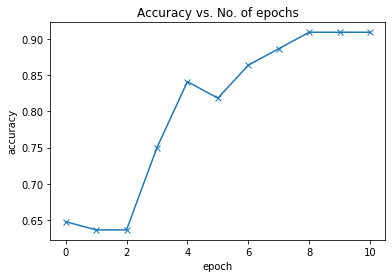

In [36]:
plot_accuracies(history)

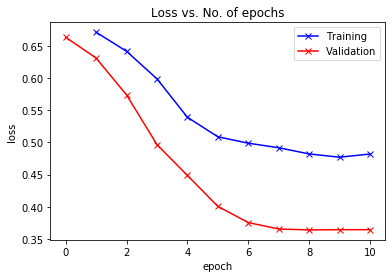

In [37]:
plot_losses(history)

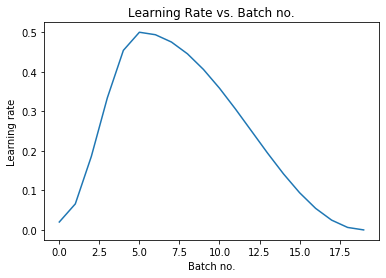

In [38]:
plot_lrs(history)

## Save the Model

Now we need to save our model by writing its state which means all of its parameters to a file and log our hyperparameters, final accuracy and final loss so we can later easily compare different model architectures and different choices of hyperparameters to see how well they perform.

In [39]:
result = evaluate(model, val_loader)
result

{'val_loss': 0.3643049895763397, 'val_acc': 0.9090909361839294}

In [40]:
torch.save(model.state_dict(), 'titanic-logistic.pth')

Note that when looking at the weights from the `model.state_dict()` output we can see how important each of the input values is. For example we can see that the class is associated with a negative value which is good since people from a class described with a higher number like class 3 were much less likely to survive. The next weight shows the extreme importance of the sex for the prediction as it is associated with the largest negative value which can be understood if you know that a man is represented with 1 and a woman with 0. What we can also deduce from the last weight is that the larger the fare paid the higher the survival probability which I think makes sense, too.

In [41]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-1.1684, -2.1230, -0.0348, -0.4453, -0.1499,  0.8619]])),
             ('linear.bias', tensor([1.5463]))])

In [42]:
jovian.reset()
jovian.log_hyperparams(arch='Ridge Logistic Regression model', 
                       epochs=epochs, 
                       lr=max_lr,
                       batch_size=batch_size,
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [43]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


## Test the Model on Samples

Having the training phase behind us we can do some testing on various single examples from the validation data to get a feeling for how well the model performs. Therefore we need to make a function which will return the models prediction for a given dataset element as well as what the person's data is and whether the person actually survived or not. As you can see in order to display the data it is important that we denormalize our data again by putting all values from the range between 0 and 1 back to their initial range and converting the categorical column Sex back to the strings female and male from the numbers 0 and 1 as which they were represented in the dataset.

In [44]:
def predict(input_data, with_label=True, verbose=True):
    if verbose:
        for i in range(len(input_cols)):
            val = input_data[0][i].item()
            if input_cols[i] == "Sex":
                val = "female" if input_data[0][i] == 0.0 else "male"
            else:
                val = round(val * (dataframe[input_cols[i]].max() - dataframe[input_cols[i]].min()) + dataframe[input_cols[i]].min(), 4)
            print(input_cols[i] + ":", val)
        print("")
    with torch.no_grad():
        pred = model(input_data[0]).item()
    print("Predicted by model..")
    if pred < 0.5:
        print("Didn't make it (Probability for survival: {:.4f})".format(pred))
    else:   
        print("A survivor!!! (Probability for survival: {:.4f})".format(pred))
    
    if with_label:
        print("")
        print("Actual result...")
        if input_data[1].item() == 0:
            print("Didn't make it")
        else:
            print("A survivor!!!", "\n")

As expected the model gets most predictions right with a survival probability that makes totally sense when looking at the input data. Even though it was wrong on the first prediction this is not a bad sign since there is also always a component of luck involved which makes a case like this not perfectly predictable and if we recall the survival probabilities for the persons of different sexes and of different classes we can see that the prediction is actually damn close to that which I think is a good sign.

In [45]:
predict(val_ds[0])

Pclass: 1.0
Sex: male
Age: 56.0
Siblings/Spouses Aboard: 0.0
Parents/Children Aboard: 0.0
Fare: 30.6958

Predicted by model..
Didn't make it (Probability for survival: 0.3660)

Actual result...
Didn't make it


In [46]:
predict(val_ds[50])

Pclass: 3.0
Sex: male
Age: 39.0
Siblings/Spouses Aboard: 1.0
Parents/Children Aboard: 5.0
Fare: 31.275

Predicted by model..
Didn't make it (Probability for survival: 0.1313)

Actual result...
Didn't make it


In [47]:
predict(val_ds[87])

Pclass: 3.0
Sex: male
Age: 36.0
Siblings/Spouses Aboard: 0.0
Parents/Children Aboard: 0.0
Fare: 6.95

Predicted by model..
Didn't make it (Probability for survival: 0.1482)

Actual result...
Didn't make it


In [48]:
predict(val_ds[22])

Pclass: 2.0
Sex: male
Age: 30.0
Siblings/Spouses Aboard: 0.0
Parents/Children Aboard: 0.0
Fare: 13.0

Predicted by model..
Didn't make it (Probability for survival: 0.2401)

Actual result...
Didn't make it


Don't you want to find out as well whether you would have survived the titanic disaster. To do this we have this nice function which asks you to input your data and then returns its prediction after converting the categorical values to numericals and normalizing the input data. Just think of a fare reasonable for your chosen class (or not and try to break the predictions). You can of course completely also make up data to test the model with that and see which people would survive.

In [49]:
# function to determine whether you would have survived the titanic sinking
# it will ask you for the passenger class(classes from 1 to 3), sex (either "male" or "female") and some other information
# note that the price unit is £
female = 0
male = 1
def will_I_survive():
    data = list()
    for i in range(len(input_cols)):
        data.append(input("Your " + input_cols[i] + "?: "))
    data = [float(item) if (item != "female" and item != "male") else float(eval(item)) for item in data]
    for col in range(len(input_cols)):
        if input_cols[col] != "Sex":
            data[col] = (data[col] - dataframe[input_cols[col]].min()) / (dataframe[input_cols[col]].max() - dataframe[input_cols[col]].min())
    print("")
    predict(torch.tensor([data], dtype=torch.float32), with_label=False, verbose=False)

In [50]:
# run this function to see whether you would have survived
will_I_survive()

Your Pclass?: 1
Your Sex?: male
Your Age?: 50
Your Siblings/Spouses Aboard?: 0
Your Parents/Children Aboard?: 0
Your Fare?: 80

Predicted by model..
Didn't make it (Probability for survival: 0.3861)


Lastly we can make a submission .csv file for the [titanic competition](https://www.kaggle.com/c/titanic) on kaggle to become first place p ;).

In [51]:
test_input_cols = "?".join(input_cols).replace("Siblings/Spouses Aboard", "SibSp").replace("Parents/Children Aboard", "Parch").split("?")
test_df = pd.read_csv("./data/test.csv")
# eleminate all nan values in the age column
test_df.loc[test_df['Age'].isnull()] = test_df['Age'].median()
# eleminate all nan values in the fare column
test_df.loc[test_df['Fare'].isnull()] = test_df['Fare'].median()
test_input_arr = dataframe_to_arrays(test_df, normalize=True, labeled=False, cols=test_input_cols)
test_inputs = torch.tensor(test_input_arr, dtype=torch.float32)
test_inputs

tensor([[0.0769, 1.0000, 0.4527, 0.0000, 0.0000, 0.0153],
        [0.0769, 0.6667, 0.6176, 0.0370, 0.0000, 0.0137],
        [0.0385, 1.0000, 0.8154, 0.0000, 0.0000, 0.0189],
        ...,
        [0.0769, 1.0000, 0.5055, 0.0000, 0.0000, 0.0142],
        [1.0000, 0.3333, 0.3538, 1.0000, 1.0000, 0.0527],
        [1.0000, 0.3333, 0.3538, 1.0000, 1.0000, 0.0527]])

In [52]:
def make_submission(inputs, out_file="./data/logistic_submission.csv"):
    submission_df = pd.read_csv("./data/gender_submission.csv")
    result = list()
    for person in inputs:
        result.append(int(round(model(person).item(), 0)))
    submission_df["Survived"] = result
    submission_df.to_csv(out_file, index=False)
    return result

In [53]:
make_submission(test_inputs, out_file="./data/logistic_submission.csv")

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [ ]:
jovian.commit(project="titanic-logistic-regression", outputs=['titanic-logistic.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


## Summary and Opportunities for future Work

Lastly I want to summarize the amazing things I learned from this nice project. The first major takeaway from this project was how to deal with pandas dataframes and data in general which was usually done for me when I was provided a starter notebook. Now that I did this project from scratch I read about the pandas library and various of its functions so I was able to use this data for my project very well. I also learned quite a bit about data normalization.

Another thing I took away from this was a lot of knowledge about Logistic Regression as I read quite a lot on the various approaches. For example I read about why you would use 1 output neuron vs 2 output neurons for binary classification and came to the result that the usage of 1 output neuron is less prone to overfitting as it has less parameters which makes totally sense. This is also why I used this for my model with the Binary Cross Entropy. Morover I learned the math behind regularization to be able to better understand it and implement it which helped a lot when implementing regularization and choosing the weight decay hyperparameter.

Not to forget are also the things I learned about the disaster by examining the data and also from additional research which was very interesting.

Summing the learning up I can just stress how great projects are for learning as by doing everything yourself you can learn it much better. I feel a lot more comfortable with the pytorch library and Machine Learning in general now.

For the future I can't wait to work on different more challenging projects with other datasets and compete in various interesting kaggle challenges with all the newly learned things to deepen my knowledge in the world of AI and have fun. I am really looking forward to doing all of the thousands of projects I have in my mind.